In [1]:
%config InlineBackend.figure_format = "retina"

import pandas as pd
import json
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
import datasets

We have several directories named results/steering-LANG-MUTATIONS-LAYERS-MODEL.
Within each of these directories, there are files called test_results.json.
Each test_results.json has fields called total and num_succ. Read all of these
into a pandas dataframe.

In [2]:
MUTATIONS_RENAMED = {
    "types": "Rename types",
    "vars": "Rename variables",
    "delete": "Remove type annotations",
    "types_vars": "Rename types and variables",
    "types_delete": "Rename types and remove type annotations",
    "vars_delete": "Rename variables and remove type annotations",
    "types_vars_delete": "All edits",
}

def read_steering_results():
    all_dfs = []
    missing_test_results = []
    for path in Path("../results").glob("steering-*"):
        test_results_path = path / "test_results.json"
        steering_path = path / "steer_results.json"
        rand_path = path / "test_results_rand.json"
        if not test_results_path.exists() or not steering_path.exists() or not rand_path.exists():
            missing_test_results.append(path)
            continue
        _steering, lang, mutations, layers, model = path.name.split("-")
        num_layers = len(layers.split("_"))
        df = pd.read_json(test_results_path, typ='series').to_frame().T
        df_rand = pd.read_json(rand_path, typ='series').to_frame().T
        df_steering = pd.read_json(steering_path, typ='series').to_frame().T
        df_rand.columns = [f"rand_{c}" for c in df_rand.columns]
        df_steering.columns = [f"steering_{c}" for c in df_steering.columns]
        df = pd.concat([df, df_rand, df_steering], axis=1)
        df["lang"] = lang
        df["mutations"] = mutations
        df["layers"] = layers
        df["start_layer"] = int(layers.split("_")[0])
        df["model"] = model
        df["num_layers"] = num_layers
        all_dfs.append(df)
    return pd.concat(all_dfs), missing_test_results

df, missing_test_results = read_steering_results()
missing_test_results

[]

In [3]:
df_pretty = df.copy()
df_pretty["mutations"] = df_pretty["mutations"].apply(lambda x: MUTATIONS_RENAMED[x])
df_pretty.head()

,num_succ,total,mean_succ,rand_num_succ,rand_total,rand_mean_succ,steering_num_succ,steering_total,steering_mean_succ,lang,mutations,layers,start_layer,model,num_layers
0,15.0,100.0,0.15,0.0,100.0,0.00,59.0,355.0,0.166197,py,Rename variables,13_14_15,13,qwen2p5_coder_7b_base,3
0,5.0,100.0,0.05,0.0,100.0,0.00,12.0,314.0,0.038217,py,Remove type annotations,1_2_3,1,qwen2p5_coder_7b_base,3
0,11.0,100.0,0.11,1.0,100.0,0.01,52.0,323.0,0.160991,py,Remove type annotations,23,23,qwen2p5_coder_7b_base,1
0,2.0,100.0,0.02,0.0,100.0,0.00,5.0,318.0,0.015723,py,Remove type annotations,14,14,qwen2p5_coder_7b_base,1
0,24.0,100.0,0.24,5.0,100.0,0.05,80.0,313.0,0.255591,py,Remove type annotations,25_26_27,25,qwen2p5_coder_7b_base,3


In [4]:
def plot_steering_results(df: pd.DataFrame, num_layers: int):
    df = df[df["num_layers"] == num_layers]
    mutations = df["mutations"].unique()
    mutations = sorted(mutations)
    num_mutations = len(mutations)
    num_cols = 3
    num_rows = (num_mutations + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, mutation in enumerate(mutations):
        subset = df[df["mutations"] == mutation]
        sns.lineplot(ax=axes[i], data=subset, x="start_layer", y="mean_succ", label="Test")
        sns.lineplot(ax=axes[i], data=subset, x="start_layer", y="steering_mean_succ", label="Steering")
        sns.lineplot(ax=axes[i], data=subset, x="start_layer", y="rand_mean_succ", label="Random")

        axes[i].set_title(mutation)
        axes[i].set_xlabel("Patch layer start")
        axes[i].set_ylabel("Accuracy")
        axes[i].set_ylim(0, 1)  # Set y-axis range from 0 to 1
        axes[i].set_xticks(range(int(df["start_layer"].min()), int(df["start_layer"].max()) + 1, 1))
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid(True, which='major', linestyle='-', linewidth=0.5, color='lightgrey')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f"{num_layers} patched layers", fontsize=16)

    plt.tight_layout()
    plt.show()

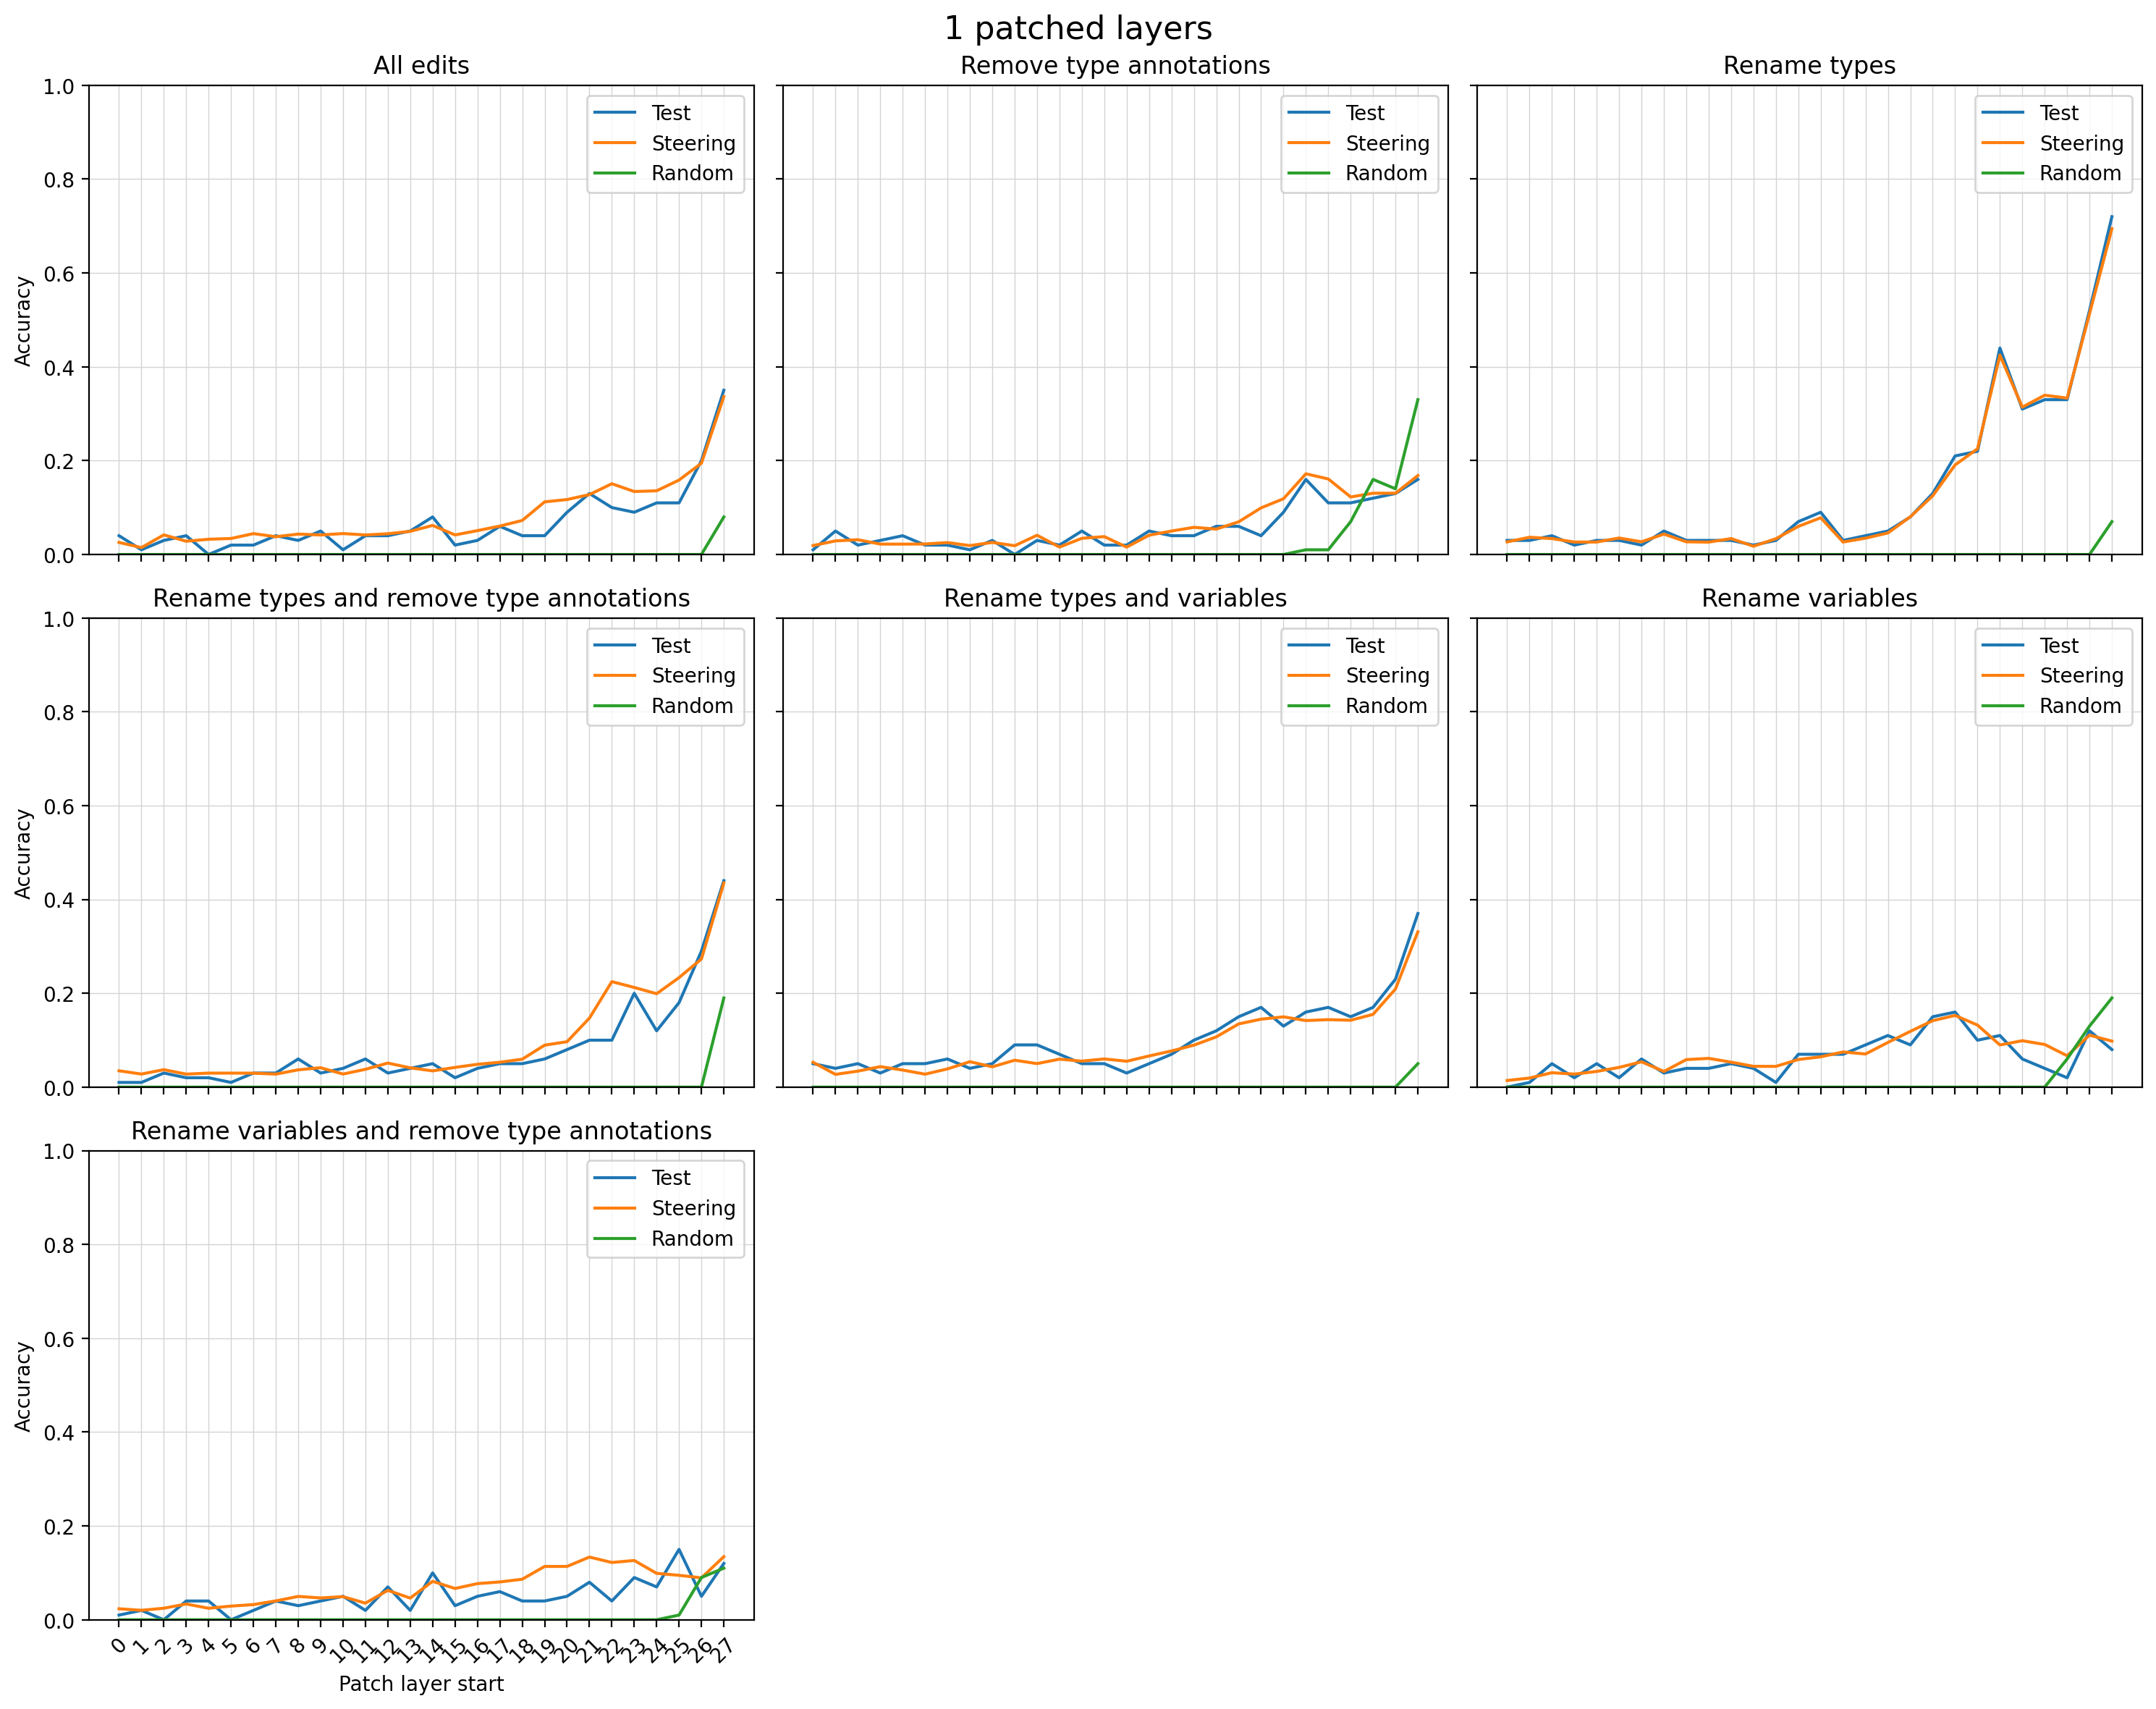

In [5]:
plot_steering_results(df_pretty, 1)

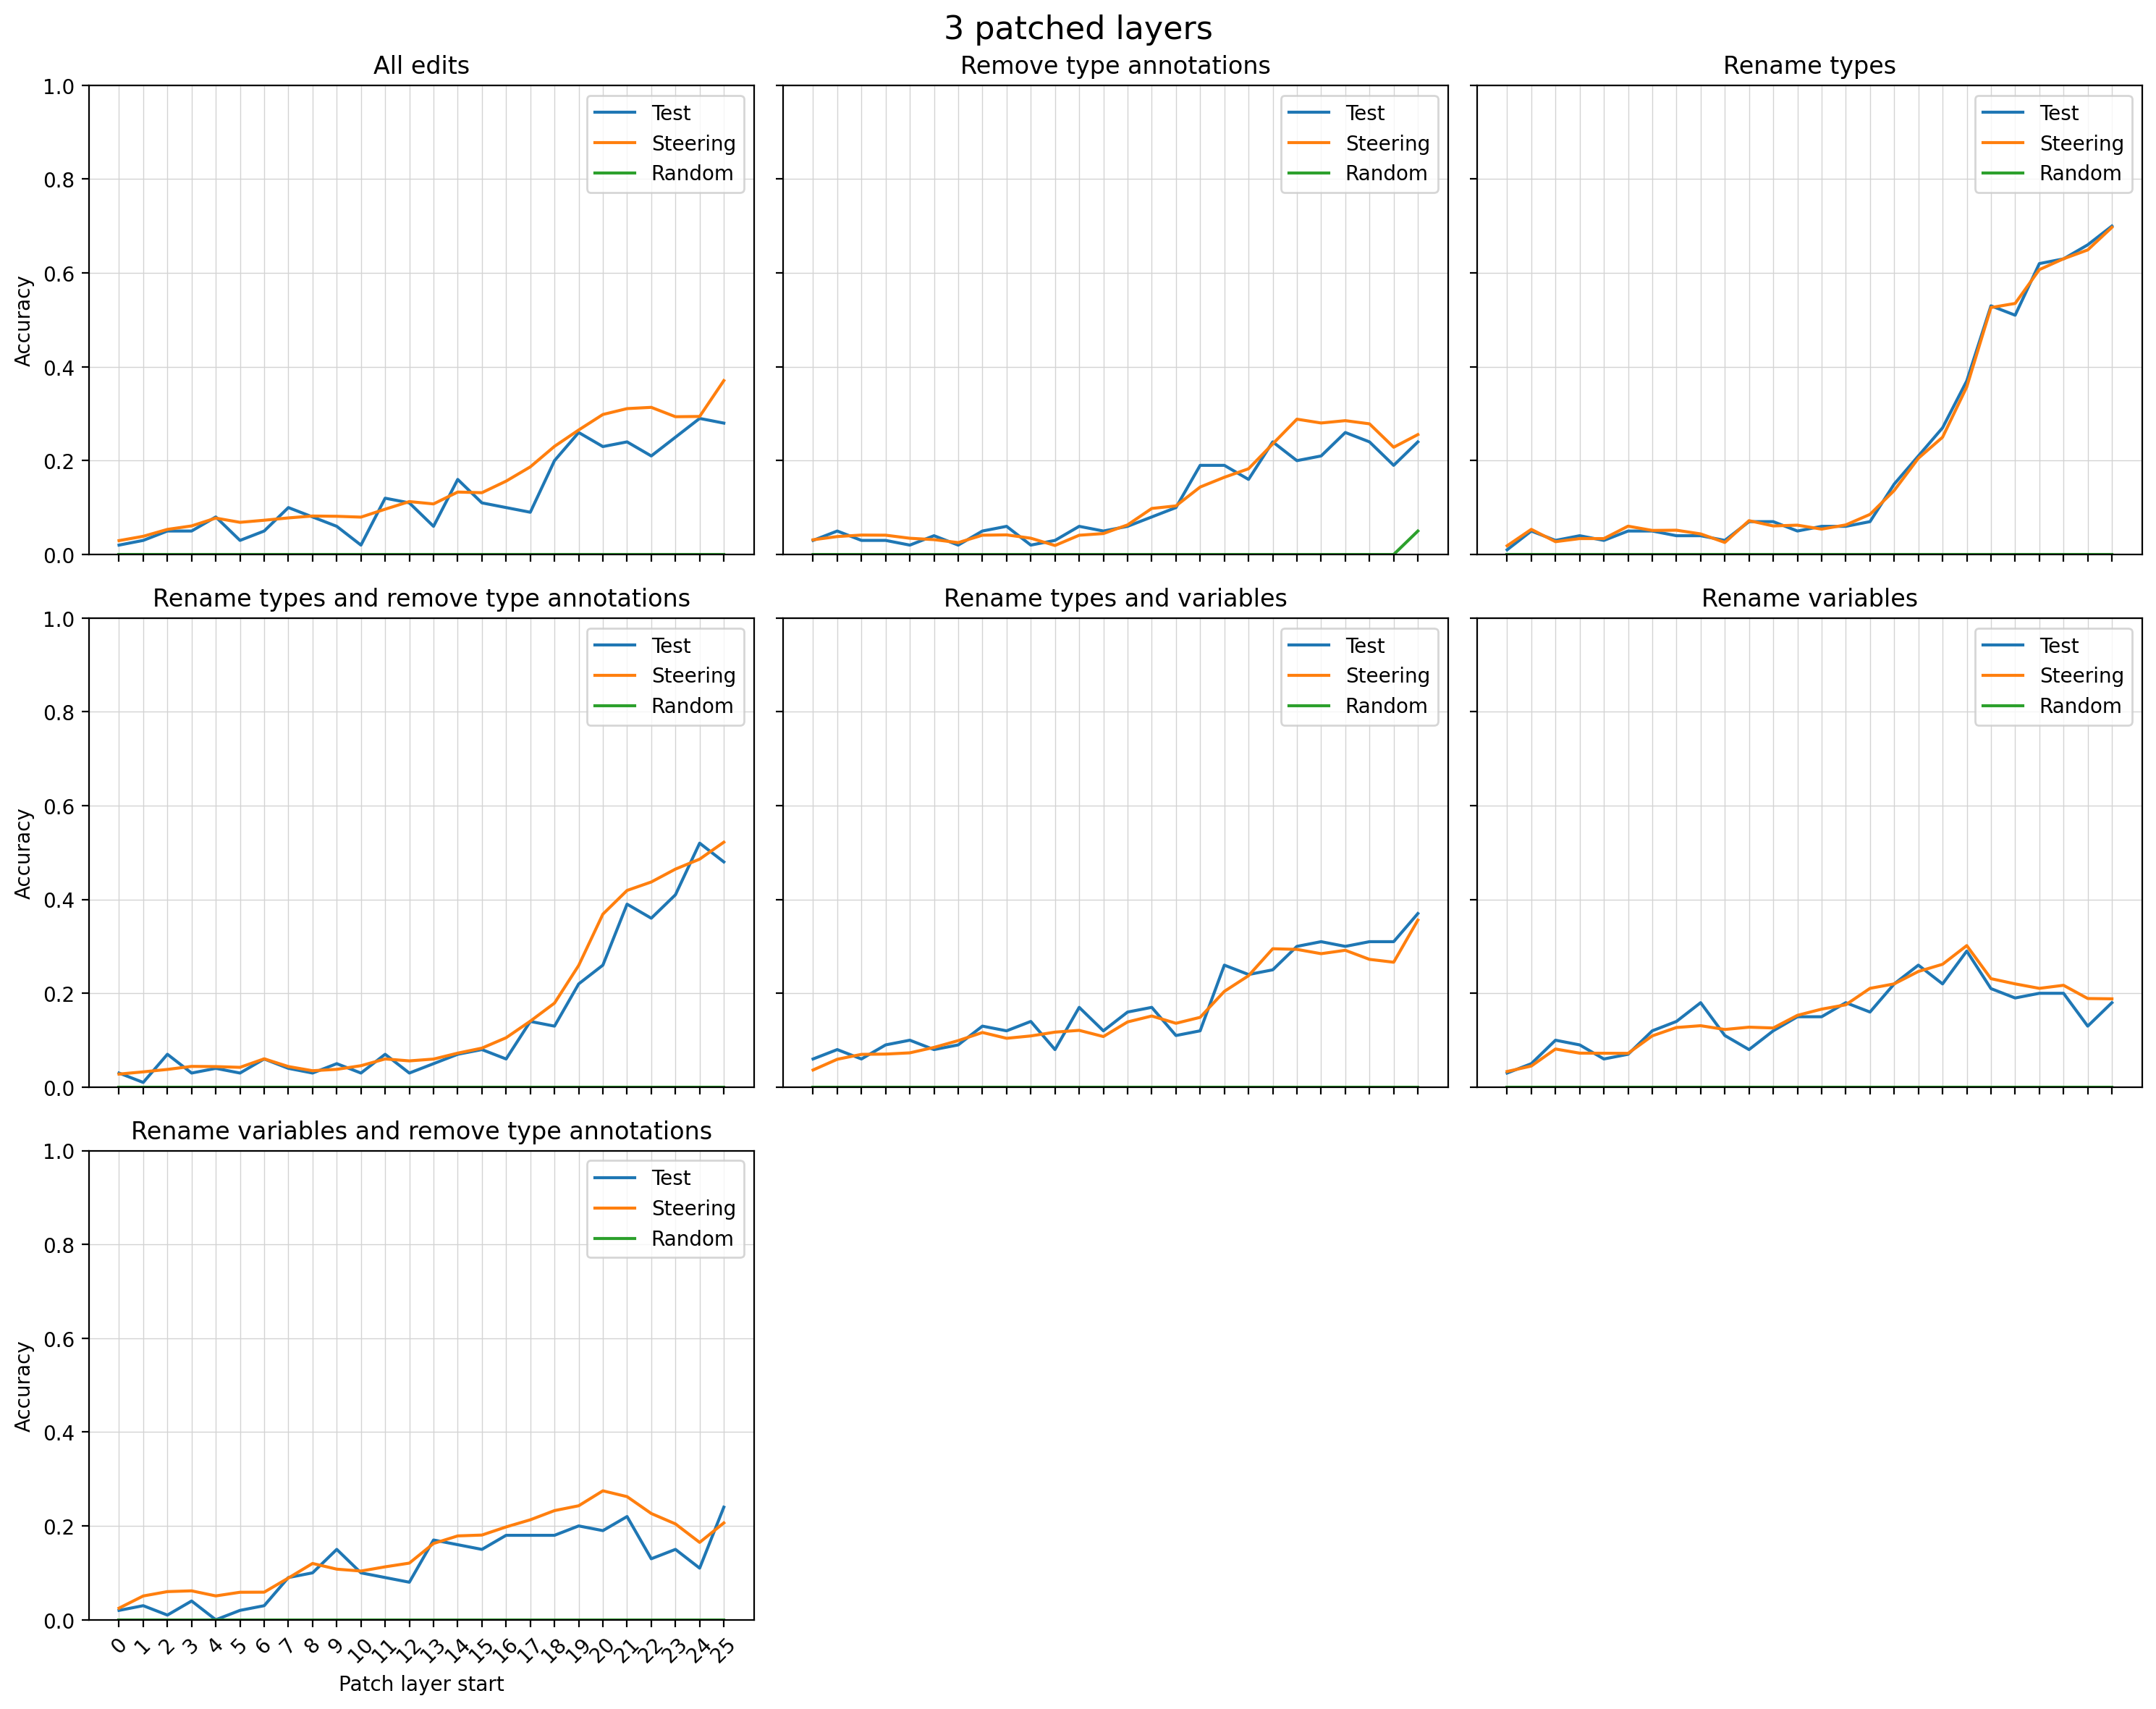

In [6]:
plot_steering_results(df_pretty, 3)

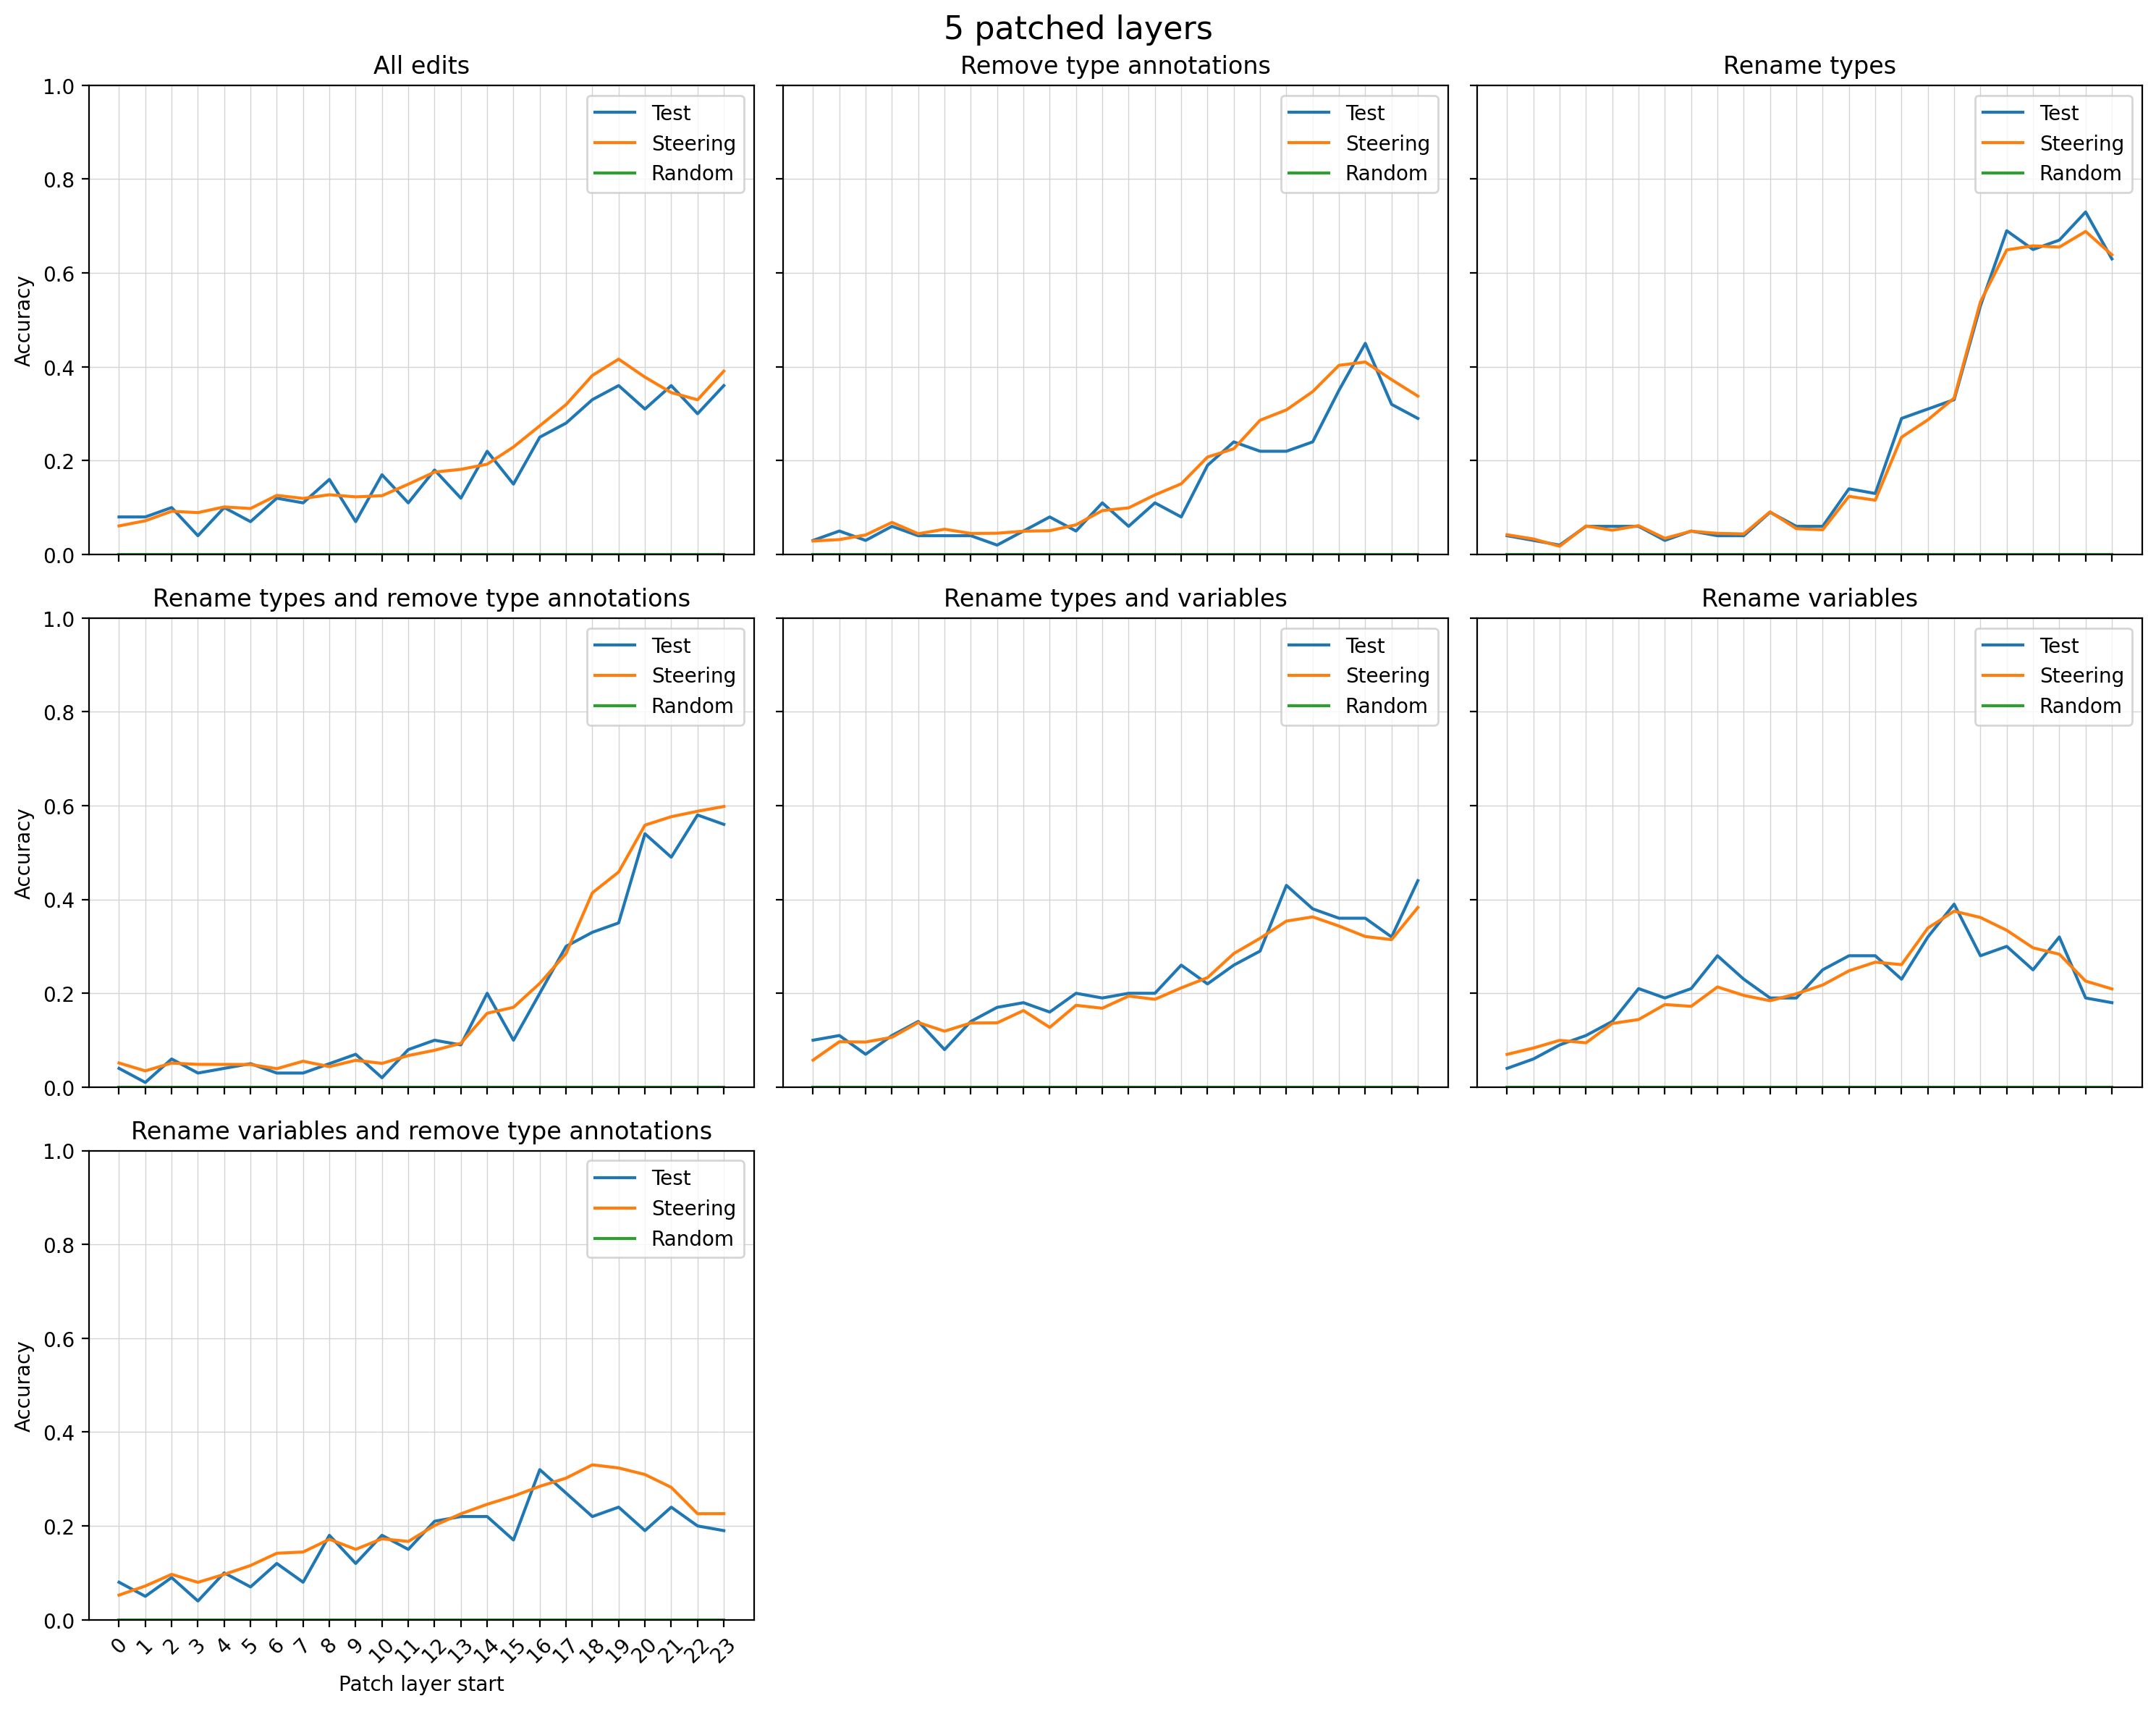

In [7]:
plot_steering_results(df_pretty, 5)

In [8]:
datasets.Dataset.from_pandas(df).push_to_hub("nuprl/type-steering", config_name="results")

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]